## 安裝 PySpark

In [0]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [0]:
! wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
! tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [0]:
! pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-1.8.0-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [8]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

data = [1,2,3,4,5]
rdd = sc.parallelize(data)
rdd
#rdd.collect()

ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:195

In [9]:
rdd.collect()

[1, 2, 3, 4, 5]

## 計算個評價的數量

In [10]:
! wget https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/u.data

--2020-05-25 05:56:02--  https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/u.data
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1979173 (1.9M) [text/plain]
Saving to: ‘u.data’

u.data              100%[===================>]   1.89M  9.31MB/s    in 0.2s    

2020-05-25 05:56:03 (9.31 MB/s) - ‘u.data’ saved [1979173/1979173]



In [11]:
! head u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [0]:
lines = sc.textFile('u.data')

In [14]:
lines

u.data MapPartitionsRDD[5] at textFile at NativeMethodAccessorImpl.java:0

In [15]:
lines.take(3)

['196\t242\t3\t881250949', '186\t302\t3\t891717742', '22\t377\t1\t878887116']

In [0]:
ratings = lines.map(lambda x: x.split()[2])


In [17]:
ratings.take(3)

['3', '3', '1']

In [0]:
result = ratings.countByValue()

In [20]:
result

defaultdict(int, {'1': 6110, '2': 11370, '3': 27145, '4': 34174, '5': 21201})

In [0]:
import collections
from collections import Counter
c = Counter(result)

In [25]:
c

Counter({'1': 6110, '2': 11370, '3': 27145, '4': 34174, '5': 21201})

## 氣溫資料轉換

In [26]:
! wget https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/1800.csv

--2020-05-25 06:07:59--  https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/1800.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62728 (61K) [text/plain]
Saving to: ‘1800.csv’

1800.csv            100%[===================>]  61.26K  --.-KB/s    in 0.03s   

2020-05-25 06:08:00 (2.08 MB/s) - ‘1800.csv’ saved [62728/62728]



In [27]:
! head 1800.csv

ITE00100554,18000101,TMAX,-75,,,E,
ITE00100554,18000101,TMIN,-148,,,E,
GM000010962,18000101,PRCP,0,,,E,
EZE00100082,18000101,TMAX,-86,,,E,
EZE00100082,18000101,TMIN,-135,,,E,
ITE00100554,18000102,TMAX,-60,,I,E,
ITE00100554,18000102,TMIN,-125,,,E,
GM000010962,18000102,PRCP,0,,,E,
EZE00100082,18000102,TMAX,-44,,,E,
EZE00100082,18000102,TMIN,-130,,,E,


In [0]:
def parseLine(line):
  fields = line.split(',')
  stationID = fields[0]
  entryType = fields[2]
  temperature = float(fields[3]) * 0.1 * (9.0 / 5.0) + 32.0
  return (stationID, entryType, temperature)


In [0]:
rdd = sc.textFile('1800.csv')
rdd2 = rdd.map(parseLine)

In [31]:
rdd2.take(3)

[('ITE00100554', 'TMAX', 18.5),
 ('ITE00100554', 'TMIN', 5.359999999999999),
 ('GM000010962', 'PRCP', 32.0)]

In [33]:
minTemps = rdd2 = rdd.map(parseLine).filter(lambda x: "TMIN" in x[1])
minTemps.take(3)

[('ITE00100554', 'TMIN', 5.359999999999999),
 ('EZE00100082', 'TMIN', 7.699999999999999),
 ('ITE00100554', 'TMIN', 9.5)]

In [0]:
stationTemps = minTemps.map(lambda e: (e[0], e[2]) )

In [35]:
stationTemps.take(3)

[('ITE00100554', 5.359999999999999),
 ('EZE00100082', 7.699999999999999),
 ('ITE00100554', 9.5)]

In [0]:
minTemps = stationTemps.reduceByKey(lambda x, y: min(x,y))


In [0]:
results = minTemps.collect()


In [38]:
for result in results:
    print(result[0] + "\t{:.2f}F".format(result[1]))


ITE00100554	5.36F
EZE00100082	7.70F


## 加總顧客消費

In [39]:
! wget https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/customer-orders.csv

--2020-05-25 06:17:34--  https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/customer-orders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 146855 (143K) [text/plain]
Saving to: ‘customer-orders.csv’

customer-orders.csv 100%[===================>] 143.41K  --.-KB/s    in 0.04s   

2020-05-25 06:17:35 (3.34 MB/s) - ‘customer-orders.csv’ saved [146855/146855]



In [40]:
! head customer-orders.csv

44,8602,37.19
35,5368,65.89
2,3391,40.64
47,6694,14.98
29,680,13.08
91,8900,24.59
70,3959,68.68
85,1733,28.53
53,9900,83.55
14,1505,4.32


In [0]:
rdd = sc.textFile("customer-orders.csv")


In [0]:
def extractCustomerPricePairs(line):
    fields = line.split(',')
    return (int(fields[0]), float(fields[2]))


In [0]:
mapped_rdd = rdd.map(extractCustomerPricePairs)


In [0]:
totalByCustomer = mapped_rdd.reduceByKey(lambda x, y: x + y)


In [0]:
ret = totalByCustomer.sortBy(lambda e: -e[1])

In [50]:
ret.take(5)

[(68, 6375.450000000001),
 (73, 6206.200000000001),
 (39, 6193.110000000001),
 (54, 6065.390000000001),
 (71, 5995.660000000002)]

## 找出最受歡迎電影

In [51]:
! head u.data

196	242	3	881250949
186	302	3	891717742
22	377	1	878887116
244	51	2	880606923
166	346	1	886397596
298	474	4	884182806
115	265	2	881171488
253	465	5	891628467
305	451	3	886324817
6	86	3	883603013


In [0]:
rdd = sc.textFile('u.data')

In [53]:
rdd.take(3)

['196\t242\t3\t881250949', '186\t302\t3\t891717742', '22\t377\t1\t878887116']

In [0]:
rdd2 = rdd.map(lambda e: (e.split()[1], 1))

In [57]:
rdd2.take(5)

[('242', 1), ('302', 1), ('377', 1), ('51', 1), ('346', 1)]

In [0]:
rdd3 = rdd2.reduceByKey(lambda x, y: x + y)

In [59]:
rdd3.take(3)

[('346', 126), ('474', 194), ('265', 227)]

In [0]:
ret = rdd3.sortBy(lambda a: -a[1])

In [61]:
ret.take(3)

[('50', 583), ('258', 509), ('100', 508)]

In [62]:
! wget https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/u.item

--2020-05-25 06:27:28--  https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/u.item
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 236347 (231K) [text/plain]
Saving to: ‘u.item’

u.item              100%[===================>] 230.81K  --.-KB/s    in 0.05s   

2020-05-25 06:27:33 (4.39 MB/s) - ‘u.item’ saved [236347/236347]



In [63]:
! head u.item

﻿1|Toy Story (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Toy%20Story%20(1995)|0|0|0|1|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0
2|GoldenEye (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?GoldenEye%20(1995)|0|1|1|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
3|Four Rooms (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Four%20Rooms%20(1995)|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|0|1|0|0
4|Get Shorty (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Get%20Shorty%20(1995)|0|1|0|0|0|1|0|0|1|0|0|0|0|0|0|0|0|0|0
5|Copycat (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Copycat%20(1995)|0|0|0|0|0|0|1|0|1|0|0|0|0|0|0|0|1|0|0
6|Shanghai Triad (Yao a yao yao dao waipo qiao) (1995)|01-Jan-1995||http://us.imdb.com/Title?Yao+a+yao+yao+dao+waipo+qiao+(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|0|0|0|0
7|Twelve Monkeys (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Twelve%20Monkeys%20(1995)|0|0|0|0|0|0|0|0|1|0|0|0|0|0|0|1|0|0|0
8|Babe (1995)|01-Jan-1995||http://us.imdb.com/M/title-exact?Babe%20(1995)|0|0|0|0|

In [0]:
moviedic = {}
with open('u.item', 'r', encoding = 'latin1') as f:
  for line in f.readlines():
    fields = line.strip().split('|')
    moviedic[str(fields[0]).strip()] = fields[1]

In [69]:
ret.take(3)

[('50', 583), ('258', 509), ('100', 508)]

In [70]:
ret.map(lambda e: (moviedic.get(e[0]), e[1]) ).take(3)

[('Star Wars (1977)', 583), ('Contact (1997)', 509), ('Fargo (1996)', 508)]

In [0]:
nameDict = sc.broadcast(moviedic)

In [0]:
#nameDict.value

In [75]:
ret.map(lambda e: (nameDict.value.get(e[0]), e[1]) ).take(3)

[('Star Wars (1977)', 583), ('Contact (1997)', 509), ('Fargo (1996)', 508)]

## 小任務
- 請使用 Spark 找出 u.data 中 評分最高的電影，並且從u.item對應出電影名稱跟評分?

In [0]:
rdd = sc.textFile('u.data')

In [0]:
rdd2 = rdd.map(lambda e: (e.split()[1], int(e.split()[2])))

In [81]:
rdd2.take(3)

[('242', 3), ('302', 3), ('377', 1)]

In [0]:
rdd_score_sum = rdd2.reduceByKey(lambda a,b:  a + b)

In [83]:
rdd_score_sum.take(3)

[('346', 459), ('474', 825), ('265', 877)]

In [0]:
rdd4 = rdd.map(lambda e: (e.split()[1], 1))

In [0]:
rdd_score_cnt = rdd4.reduceByKey(lambda a,b:  a + b)

In [88]:
rdd_score_sum.take(3)

[('346', 459), ('474', 825), ('265', 877)]

In [89]:
rdd_score_cnt.take(3)

[('346', 126), ('474', 194), ('265', 227)]

In [0]:
rdd_integrate = rdd_score_sum.join(rdd_score_cnt)

In [94]:
rdd_integrate.take(3)

[('346', (459, 126)), ('474', (825, 194)), ('265', (877, 227))]

In [100]:
ret = rdd_integrate.map(lambda e: (e[0], e[1][0]/ e[1][1])).sortBy(lambda e: -e[1])
ret.take(10)

[('814', 5.0),
 ('1293', 5.0),
 ('1599', 5.0),
 ('1467', 5.0),
 ('1201', 5.0),
 ('1189', 5.0),
 ('1500', 5.0),
 ('1536', 5.0),
 ('1653', 5.0),
 ('1122', 5.0)]

In [0]:
moviedic = {}
with open('u.item', 'r', encoding = 'latin1') as f:
  for line in f.readlines():
    fields = line.strip().split('|')
    moviedic[str(fields[0]).strip()] = fields[1]
nameDic = sc.broadcast(moviedic)

In [102]:
ret.map(lambda e: (nameDic.value.get(e[0]), e[1])).take(10)

[('Great Day in Harlem, A (1994)', 5.0),
 ('Star Kid (1997)', 5.0),
 ("Someone Else's America (1995)", 5.0),
 ('Saint of Fort Washington, The (1993)', 5.0),
 ('Marlene Dietrich: Shadow and Light (1996) ', 5.0),
 ('Prefontaine (1997)', 5.0),
 ('Santa with Muscles (1996)', 5.0),
 ('Aiqing wansui (1994)', 5.0),
 ('Entertaining Angels: The Dorothy Day Story (1996)', 5.0),
 ('They Made Me a Criminal (1939)', 5.0)]

## SparkSQL 與 Spark DataFrame

In [0]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [104]:
! wget "https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/Creditability.csv"


--2020-05-25 07:18:09--  https://raw.githubusercontent.com/ywchiu/taipeifubon/master/data/Creditability.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33774 (33K) [text/plain]
Saving to: ‘Creditability.csv’

Creditability.csv   100%[===================>]  32.98K  --.-KB/s    in 0.01s   

2020-05-25 07:18:09 (2.23 MB/s) - ‘Creditability.csv’ saved [33774/33774]



In [105]:
! head Creditability.csv

"","Creditability","Account.Balance","Duration.of.Credit..month.","Payment.Status.of.Previous.Credit","Purpose","Credit.Amount","Value.Savings.Stocks","Length.of.current.employment","Instalment.per.cent","Sex...Marital.Status","Guarantors","Duration.in.Current.address","Most.valuable.available.asset","Age..years.","Concurrent.Credits","Type.of.apartment","No.of.Credits.at.this.Bank","Occupation","No.of.dependents","Telephone","Foreign.Worker"
"497","1","3",6,"2","3",2108,1,3,2,"3",1,2,"1",29,2,"1",1,1,1,1,1
"756","0","1",15,"1","4",950,1,4,4,"2",1,3,"3",33,2,"1",2,1,2,1,1
"580","0","1",42,"2","3",7174,4,3,4,"1",1,3,"3",30,2,"2",1,1,1,2,1
"833","0","3",36,"3","4",7980,4,1,4,"2",1,4,"3",27,2,"1",2,1,1,2,1
"602","1","3",24,"3","2",2028,1,3,2,"2",1,2,"2",30,2,"2",2,1,1,1,1
"734","1","1",15,"2","4",2511,1,1,1,"1",1,4,"3",23,2,"1",1,1,1,1,1
"303","1","3",24,"2","2",3749,1,1,2,"1",1,4,"3",26,2,"2",1,1,1,1,1
"923","0","1",24,"2","4",1442,1,3,4,"1",1,4,"3",23,2,"1",2,1,1,1,1
"677","1","1",9,"3"

In [0]:
df = sqlContext.read.csv('Creditability.csv', header = True)

In [107]:
df

DataFrame[_c0: string, Creditability: string, Account.Balance: string, Duration.of.Credit..month.: string, Payment.Status.of.Previous.Credit: string, Purpose: string, Credit.Amount: string, Value.Savings.Stocks: string, Length.of.current.employment: string, Instalment.per.cent: string, Sex...Marital.Status: string, Guarantors: string, Duration.in.Current.address: string, Most.valuable.available.asset: string, Age..years.: string, Concurrent.Credits: string, Type.of.apartment: string, No.of.Credits.at.this.Bank: string, Occupation: string, No.of.dependents: string, Telephone: string, Foreign.Worker: string]

In [108]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Creditability: string (nullable = true)
 |-- Account.Balance: string (nullable = true)
 |-- Duration.of.Credit..month.: string (nullable = true)
 |-- Payment.Status.of.Previous.Credit: string (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Credit.Amount: string (nullable = true)
 |-- Value.Savings.Stocks: string (nullable = true)
 |-- Length.of.current.employment: string (nullable = true)
 |-- Instalment.per.cent: string (nullable = true)
 |-- Sex...Marital.Status: string (nullable = true)
 |-- Guarantors: string (nullable = true)
 |-- Duration.in.Current.address: string (nullable = true)
 |-- Most.valuable.available.asset: string (nullable = true)
 |-- Age..years.: string (nullable = true)
 |-- Concurrent.Credits: string (nullable = true)
 |-- Type.of.apartment: string (nullable = true)
 |-- No.of.Credits.at.this.Bank: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- No.of.dependents: string (nullable = 

In [109]:
df.show(5)

+---+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+-------------------+--------------------+----------+---------------------------+-----------------------------+-----------+------------------+-----------------+--------------------------+----------+----------------+---------+--------------+
|_c0|Creditability|Account.Balance|Duration.of.Credit..month.|Payment.Status.of.Previous.Credit|Purpose|Credit.Amount|Value.Savings.Stocks|Length.of.current.employment|Instalment.per.cent|Sex...Marital.Status|Guarantors|Duration.in.Current.address|Most.valuable.available.asset|Age..years.|Concurrent.Credits|Type.of.apartment|No.of.Credits.at.this.Bank|Occupation|No.of.dependents|Telephone|Foreign.Worker|
+---+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+----------------

In [0]:
import pandas
df2 = pandas.read_csv('Creditability.csv', index_col = 0)

In [114]:
df2.head()

,Creditability,Account.Balance,Duration.of.Credit..month.,Payment.Status.of.Previous.Credit,Purpose,Credit.Amount,Value.Savings.Stocks,Length.of.current.employment,Instalment.per.cent,Sex...Marital.Status,Guarantors,Duration.in.Current.address,Most.valuable.available.asset,Age..years.,Concurrent.Credits,Type.of.apartment,No.of.Credits.at.this.Bank,Occupation,No.of.dependents,Telephone,Foreign.Worker
497,1,3,6,2,3,2108,1,3,2,3,1,2,1,29,2,1,1,1,1,1,1
756,0,1,15,1,4,950,1,4,4,2,1,3,3,33,2,1,2,1,2,1,1
580,0,1,42,2,3,7174,4,3,4,1,1,3,3,30,2,2,1,1,1,2,1
833,0,3,36,3,4,7980,4,1,4,2,1,4,3,27,2,1,2,1,1,2,1
602,1,3,24,3,2,2028,1,3,2,2,1,2,2,30,2,2,2,1,1,1,1


In [0]:
spark_df = sqlContext.createDataFrame(df2) 

In [117]:
spark_df.show(5)

+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+-------------------+--------------------+----------+---------------------------+-----------------------------+-----------+------------------+-----------------+--------------------------+----------+----------------+---------+--------------+
|Creditability|Account.Balance|Duration.of.Credit..month.|Payment.Status.of.Previous.Credit|Purpose|Credit.Amount|Value.Savings.Stocks|Length.of.current.employment|Instalment.per.cent|Sex...Marital.Status|Guarantors|Duration.in.Current.address|Most.valuable.available.asset|Age..years.|Concurrent.Credits|Type.of.apartment|No.of.Credits.at.this.Bank|Occupation|No.of.dependents|Telephone|Foreign.Worker|
+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+-------------------+--------

In [118]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- Creditability: string (nullable = true)
 |-- Account.Balance: string (nullable = true)
 |-- Duration.of.Credit..month.: string (nullable = true)
 |-- Payment.Status.of.Previous.Credit: string (nullable = true)
 |-- Purpose: string (nullable = true)
 |-- Credit.Amount: string (nullable = true)
 |-- Value.Savings.Stocks: string (nullable = true)
 |-- Length.of.current.employment: string (nullable = true)
 |-- Instalment.per.cent: string (nullable = true)
 |-- Sex...Marital.Status: string (nullable = true)
 |-- Guarantors: string (nullable = true)
 |-- Duration.in.Current.address: string (nullable = true)
 |-- Most.valuable.available.asset: string (nullable = true)
 |-- Age..years.: string (nullable = true)
 |-- Concurrent.Credits: string (nullable = true)
 |-- Type.of.apartment: string (nullable = true)
 |-- No.of.Credits.at.this.Bank: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- No.of.dependents: string (nullable = 

In [119]:
df.select('Creditability').show(5)

+-------------+
|Creditability|
+-------------+
|            1|
|            0|
|            0|
|            0|
|            1|
+-------------+
only showing top 5 rows



In [122]:
df.select('`Creditability`', '`Account.Balance`').show(5)

+-------------+---------------+
|Creditability|Account.Balance|
+-------------+---------------+
|            1|              3|
|            0|              1|
|            0|              1|
|            0|              3|
|            1|              3|
+-------------+---------------+
only showing top 5 rows



In [125]:
from pyspark.sql.functions import col
df.select(
    col('`Creditability`'), 
    col('`Account.Balance`').alias('account_balance')).show(5)

+-------------+---------------+
|Creditability|account_balance|
+-------------+---------------+
|            1|              3|
|            0|              1|
|            0|              1|
|            0|              3|
|            1|              3|
+-------------+---------------+
only showing top 5 rows



In [126]:
(
    df.select(
    col('`Creditability`'), 
    col('`Account.Balance`').alias('account_balance'))
    .show(5)
)

+-------------+---------------+
|Creditability|account_balance|
+-------------+---------------+
|            1|              3|
|            0|              1|
|            0|              1|
|            0|              3|
|            1|              3|
+-------------+---------------+
only showing top 5 rows



In [127]:
df.filter(col('Creditability') == 1).show(5)

+---+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+-------------------+--------------------+----------+---------------------------+-----------------------------+-----------+------------------+-----------------+--------------------------+----------+----------------+---------+--------------+
|_c0|Creditability|Account.Balance|Duration.of.Credit..month.|Payment.Status.of.Previous.Credit|Purpose|Credit.Amount|Value.Savings.Stocks|Length.of.current.employment|Instalment.per.cent|Sex...Marital.Status|Guarantors|Duration.in.Current.address|Most.valuable.available.asset|Age..years.|Concurrent.Credits|Type.of.apartment|No.of.Credits.at.this.Bank|Occupation|No.of.dependents|Telephone|Foreign.Worker|
+---+-------------+---------------+--------------------------+---------------------------------+-------+-------------+--------------------+----------------------------+----------------

In [129]:
df.select(
    col('`Creditability`'), 
    col('`Account.Balance`').alias('account_balance')  
).filter(col('Creditability') == 1).show(5)

+-------------+---------------+
|Creditability|account_balance|
+-------------+---------------+
|            1|              3|
|            1|              3|
|            1|              1|
|            1|              3|
|            1|              1|
+-------------+---------------+
only showing top 5 rows



In [131]:
# SELECT Creditability,AVG(`Credit.Amount`) AS Credit_Amount FROM df 
# GROUP BY Creditability ORDER BY Credit_Amount DESC;
from pyspark.sql import functions
cnt_df = (df
      .groupby(col('Creditability'))
      .agg(functions.mean('`Credit.Amount`').alias('Credit_Amount'))
      .sort(functions.desc('Credit_Amount'))
    )
cnt_df.show(5)


+-------------+------------------+
|Creditability|     Credit_Amount|
+-------------+------------------+
|            0| 4102.174825174825|
|            1|2897.5826330532213|
+-------------+------------------+



In [0]:
df2 = cnt_df.toPandas() 

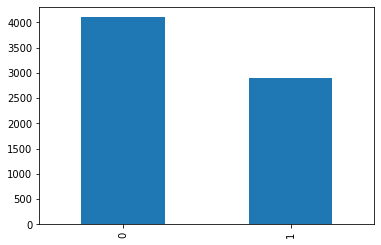

In [135]:
df2['Credit_Amount'].plot(kind = 'bar')

In [138]:
import pandas
code_table = pandas.DataFrame(
    [{'codename': 'credible', 'code': 1},{'codename': 'not credible', 'code': 0}])
code_table

,codename,code
0,credible,1
1,not credible,0


In [0]:
spark_code_table = sqlContext.createDataFrame(code_table).alias('code_df')

In [0]:
cnt_df = cnt_df.alias('cnt_df')

In [144]:
# SELECT cnt_df.*, code_df.codename FROM cnt_df cnt_df 
# INNER JOIN spark_code_table code_df
# ON cnt_df.Creditability =code_df.code
cnt_df.join(
    spark_code_table, col('cnt_df.Creditability') == col('code_df.code')
    ).select(
    'cnt_df.*',
    'code_df.codename'
).show(5)


+-------------+------------------+------------+
|Creditability|     Credit_Amount|    codename|
+-------------+------------------+------------+
|            1|2897.5826330532213|    credible|
|            0| 4102.174825174825|not credible|
+-------------+------------------+------------+



## Spark SQL

In [0]:
sqlContext.registerDataFrameAsTable(df, "Creditability_Data")

In [151]:
stat_data = sqlContext.sql("""
  SELECT Creditability,AVG(`Credit.Amount`) AS credit_amount
  FROM Creditability_Data
  GROUP BY Creditability
  ORDER BY credit_amount DESC
""")
stat_data.show()
sqlContext.dropTempTable("Creditability_Data")

+-------------+------------------+
|Creditability|     credit_amount|
+-------------+------------------+
|            0| 4102.174825174825|
|            1|2897.5826330532213|
+-------------+------------------+



In [152]:
stat_data = sqlContext.sql("""
  SELECT Creditability,AVG(`Credit.Amount`) AS credit_amount
  FROM Creditability_Data
  GROUP BY Creditability
  ORDER BY credit_amount DESC
""")

ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



AnalysisException: ignored

## Pyspark ETL Example
- https://github.com/AlexIoannides/pyspark-example-project

## 小任務
- 請使用 Spark 將 u.data 轉換成 Spark DataFrame 並命名為 movie_ratings ，並將 u.item 轉換為 Spark DataFrame 並命名為 movie_names，接者使用 SparkSQL 找出最受歡迎的10大電影，並且對應出電影名稱跟觀賞次數?